# DRIVER CLUSTERING ANALYSIS

Mục tiêu là để hỗ trợ doanh nghiệp tối ưu hóa phân bổ tài xế, quản lý và tuyển chọn nhân sự hiệu quả. Áp dụng phân cụm giúp phân nhóm tài xế dựa trên các đặc trưng hành vi mà không cần nhãn đầu ra (ví dụ: tài xế kỳ cựu hiệu suất cao, tài xế mới, hoặc tài xế ở khu vực giao thông đông đúc). 

**1. IMPORT DATA**

In [ ]:
# Ẩn toàn bộ warning
import warnings
warnings.filterwarnings("ignore")

# Xử lý và phân tích dữ liệu
import numpy as np
import pandas as pd
import seaborn as sns

# Vẽ biểu đồ
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Machine Learning
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score


In [ ]:
df= pd.read_csv('C:\Học tập\FoodDelivery_TimePrediction_Clustering\Data\delivery_time_cleaned.csv')

In [3]:
df.dtypes

ID                              object
Delivery_person_ID              object
Delivery_person_Age              int64
Delivery_person_Ratings        float64
Order_Date                      object
Weatherconditions               object
Road_traffic_density            object
Vehicle_condition                int64
Type_of_order                   object
Type_of_vehicle                 object
multiple_deliveries              int64
Festival                        object
Area_Type                       object
Time_taken(min)                  int64
City_name                       object
Time_Order_picked_formatted     object
Time_Ordered_formatted          object
Distance_km                    float64
dtype: object

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Delivery_person_Age,41901.0,28.009045,5.634575,20.000000,23.000000,27.000000,33.000000,39.000000
Delivery_person_Ratings,41901.0,4.635307,0.328563,1.000000,4.500000,4.700000,4.800000,6.000000
Vehicle_condition,41901.0,1.022744,0.838929,0.000000,0.000000,1.000000,2.000000,3.000000
multiple_deliveries,41901.0,0.750650,0.567051,0.000000,0.000000,1.000000,1.000000,3.000000
Time_taken(min),41901.0,26.309133,9.379667,10.000000,19.000000,26.000000,32.000000,54.000000
Distance_km,41901.0,10.548272,6.106920,0.257182,5.617894,9.730059,14.668513,31.830481


In [4]:
df.describe(exclude=np.number).T

,count,unique,top,freq
ID,41901,41901,0x4607,1
Delivery_person_ID,41901,1167,JAPRES11DEL02,67
Order_Date,41901,44,2022-03-15,1115
Weatherconditions,41901,6,Fog,7137
Road_traffic_density,41901,4,Low,14728
Type_of_order,41901,4,Snack,10603
Type_of_vehicle,41901,4,motorcycle,24368
Festival,41901,2,No,41080
Area_Type,41901,3,Metropolitian,32482
City_name,41901,22,Jaipur,3443


**2. Xử lý ngày tháng:**

 - Chuyển đổi Order_Date thành kiểu datetime để dễ dàng xử lý thời gian. Chuyển đổi thời gian đặt hàng và thời gian lấy hàng sang timedelta.

In [5]:
df['Time_Order_picked_formatted'] = pd.to_datetime(df['Time_Order_picked_formatted'], format="%Y-%m-%d %H:%M:%S")
df['Time_Ordered_formatted'] = pd.to_datetime(df['Time_Ordered_formatted'], format="%Y-%m-%d %H:%M:%S")

In [6]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Order_Date,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,Area_Type,Time_taken(min),City_name,Time_Order_picked_formatted,Time_Ordered_formatted,Distance_km
0,0x4607,INDORES13DEL02,37,4.9,2022-03-19,Sunny,High,2,Snack,motorcycle,0,No,Urban,24,Indore,2022-03-19 11:45:00,2022-03-19 11:30:00,4.599023
1,0xb379,BANGRES18DEL02,21,4.5,2022-03-25,Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,33,Bangalore,2022-03-25 19:50:00,2022-03-25 19:45:00,19.995664
2,0x5d6d,BANGRES19DEL01,23,4.4,2022-03-19,Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,26,Bangalore,2022-03-19 08:45:00,2022-03-19 08:30:00,7.998623
3,0x7a6a,COIMBRES13DEL02,24,4.7,2022-04-05,Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,21,Coimbatore,2022-04-05 18:10:00,2022-04-05 18:00:00,3.401680
4,0x70a2,CHENRES12DEL01,20,4.6,2022-03-26,Cloudy,High,1,Snack,scooter,1,No,Metropolitian,30,Chennai,2022-03-26 13:45:00,2022-03-26 13:30:00,5.813103


# **Delivery Person K-Means Cluster**

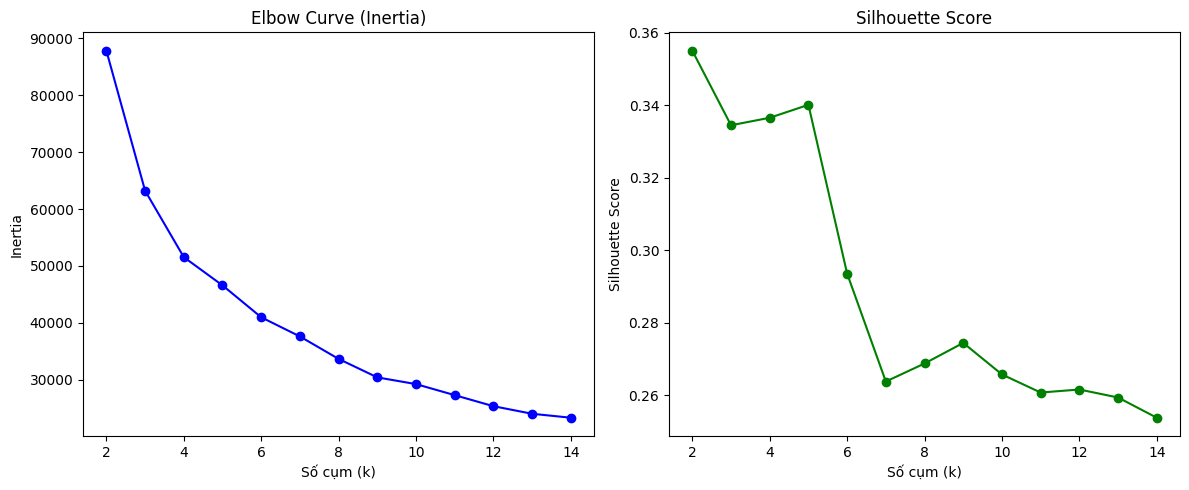

In [7]:
# 1. Lựa chọn đặc trưng
selected_features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Time_taken(min)']
features_df = df[selected_features].dropna()  # Bỏ các dòng chứa giá trị thiếu

# 2. Chuẩn hóa dữ liệu
X = StandardScaler().fit_transform(features_df)

# 3. Thử các số cụm từ 2 đến 14
cluster_range = range(2, 15)
inertia_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# 4. Vẽ biểu đồ Elbow và Silhouette
plt.figure(figsize=(12, 5))

# Elbow Curve
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o', color='blue')
plt.title('Elbow Curve (Inertia)')
plt.xlabel('Số cụm (k)')
plt.ylabel('Inertia')

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Số cụm (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

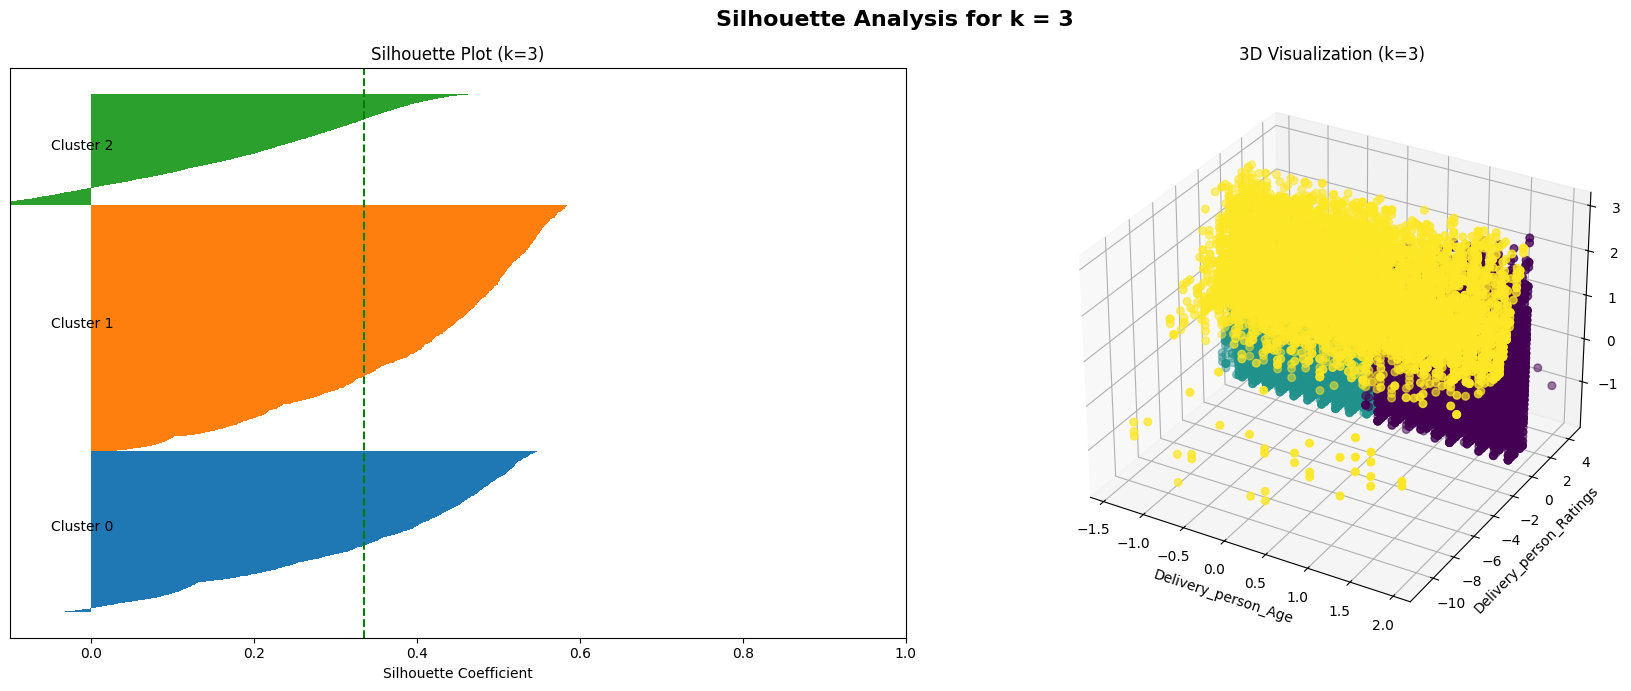

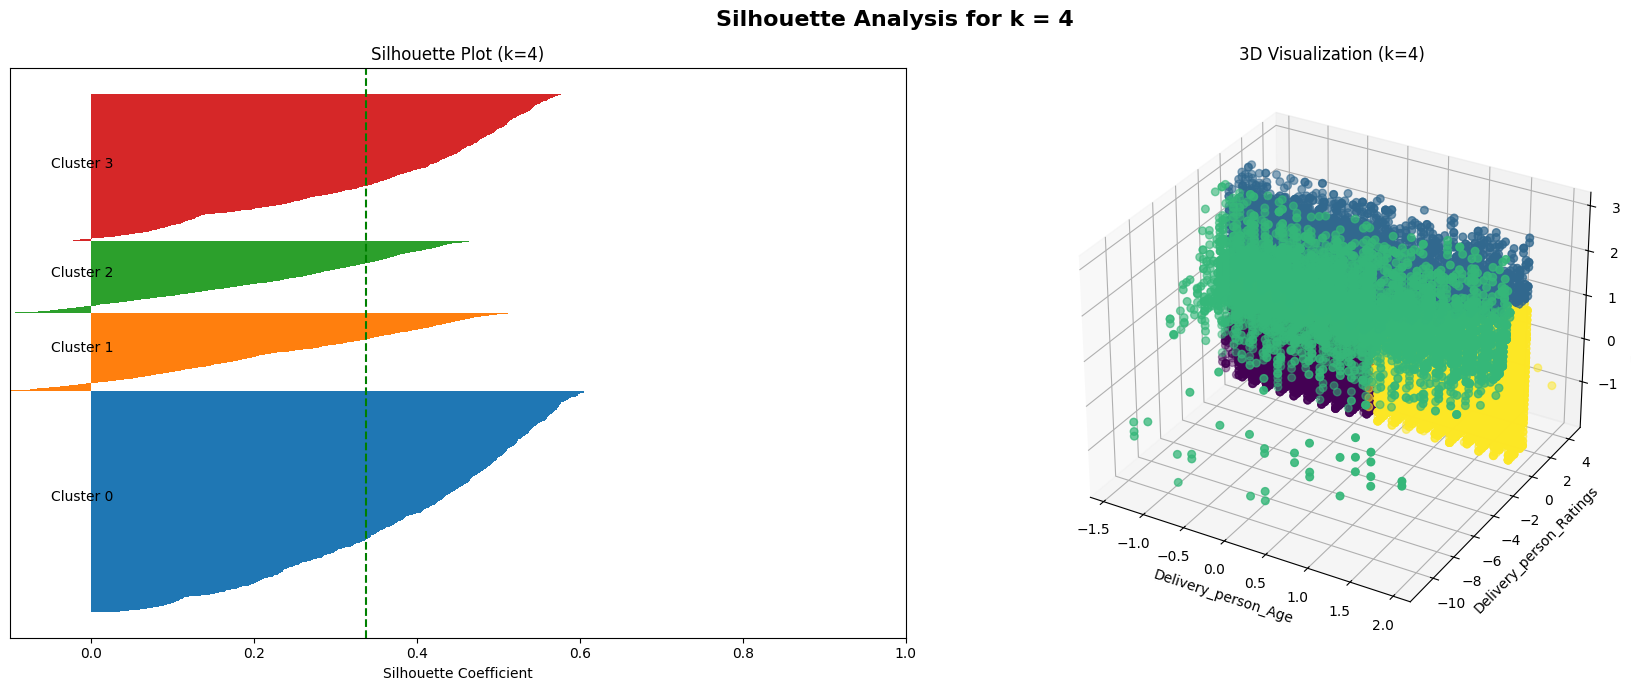

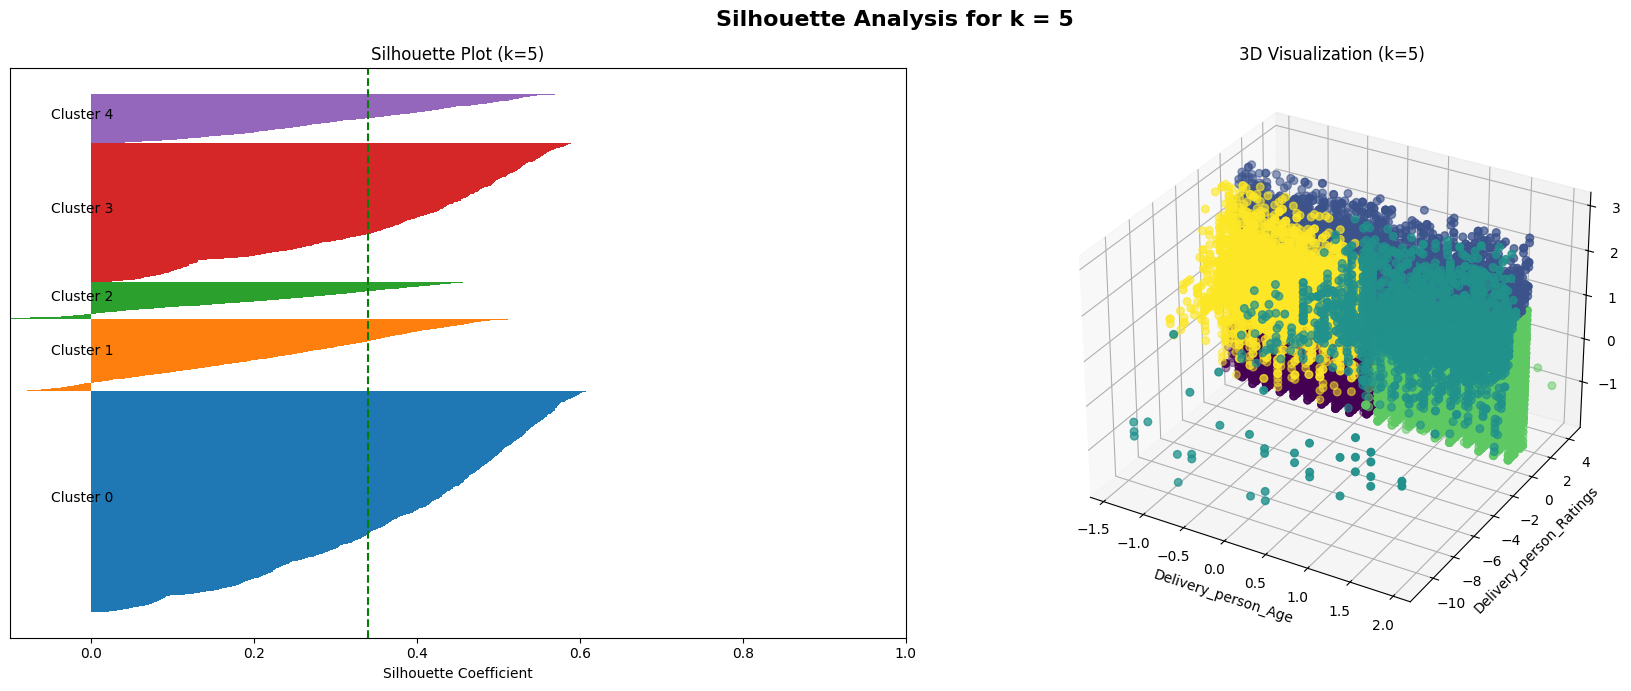

In [ ]:

# ================================
# Hàm vẽ silhouette + 3D plot
# ================================

def plot_silhouette_and_clusters(X, feature_names, k):
    fig = plt.figure(figsize=(18, 7))

    # 1. KMeans
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_

    # 2. Silhouette values
    silhouette_vals = silhouette_samples(X, labels)
    avg_score = np.mean(silhouette_vals)

    # ===============================
    # Silhouette Plot
    # ===============================
    ax1 = fig.add_subplot(121)
    y_lower = 0

    for cluster in np.unique(labels):
        cluster_vals = np.sort(silhouette_vals[labels == cluster])
        y_upper = y_lower + len(cluster_vals)

        ax1.barh(range(y_lower, y_upper), cluster_vals, height=1.0, edgecolor='none')
        ax1.text(-0.05, (y_lower + y_upper) / 2, f'Cluster {cluster}')
        y_lower = y_upper

    ax1.axvline(avg_score, linestyle='--', color='green')
    ax1.set_xlim([-0.1, 1])
    ax1.set_yticks([])
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_title(f"Silhouette Plot (k={k})")

    # ===============================
    # 3D Scatter Plot
    # ===============================
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='viridis', s=30)
    ax2.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
                c='red', s=250, marker='*')

    ax2.set_xlabel(feature_names[0])
    ax2.set_ylabel(feature_names[1])
    ax2.set_zlabel(feature_names[2])
    ax2.set_title(f"3D Visualization (k={k})")

    plt.suptitle(f"Silhouette Analysis for k = {k}", fontsize=16, fontweight='semibold')
    plt.tight_layout()
    plt.show()


# ================================
# Gọi hàm cho k = 3, 4, 5
# ================================

plot_features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Time_taken(min)']

for k in [3, 4, 5]:
    plot_silhouette_and_clusters(X, plot_features, k)


In [ ]:

# ================================
# 1. Hàm tính BSS nhanh & chuẩn
# ================================

def compute_bss(X_original, labels, centroids):
    """
    BSS = sum_{clusters} n_k * ||centroid_k - mean_global||^2
    """
    global_mean = X_original.mean(axis=0).values  # dùng dữ liệu gốc (chưa scale)
    cluster_sizes = np.bincount(labels)

    return np.sum(cluster_sizes[:, None] * (centroids - global_mean)**2)


# ================================
# 2. Chạy KMeans với k = 5
# ================================

k = 5
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
labels = kmeans.fit_predict(X)

# Tạo DataFrame chứa kết quả phân cụm
person_cluster_df = features_df.copy()
person_cluster_df["cluster"] = labels


# ================================
# 3. In thống kê & chỉ số đánh giá
# ================================

print("Số lượng phần tử mỗi cụm:")
print(person_cluster_df["cluster"].value_counts(), "\n")

# WSS (inertia_)
wss = kmeans.inertia_
print("WSS (Within-Cluster Sum of Squares):", wss)

# BSS
bss = compute_bss(features_df, labels, kmeans.cluster_centers_)
print("BSS (Between-Cluster Sum of Squares):", bss)

# Silhouette
sil_score = silhouette_score(X, labels)
print("Silhouette Score:", sil_score)

# Calinski-Harabasz
ch_score = calinski_harabasz_score(X, labels)
print("Calinski-Harabasz Score:", ch_score)


Số lượng phần tử mỗi cụm:
cluster
0    17858
3    11218
1     5846
4     3988
2     2991
Name: count, dtype: int64 

WSS (Within-Cluster Sum of Squares): 46586.48016224078
BSS (Between-Cluster Sum of Squares): 62851210.34477155
Silhouette Score: 0.3401419538409973
Calinski-Harabasz Score: 17787.765175970962


In [10]:
person_cluster_df.groupby("cluster")
person_cluster_df.head(20)

,Delivery_person_Age,Delivery_person_Ratings,Time_taken(min),cluster
0,37,4.9,24,3
1,21,4.5,33,4
2,23,4.4,26,0
3,24,4.7,21,0
4,20,4.6,30,0
5,21,4.8,26,0
6,28,4.7,40,1
7,30,4.6,32,1
8,22,4.8,34,1
9,22,4.2,46,4


**Phân bổ cụm**

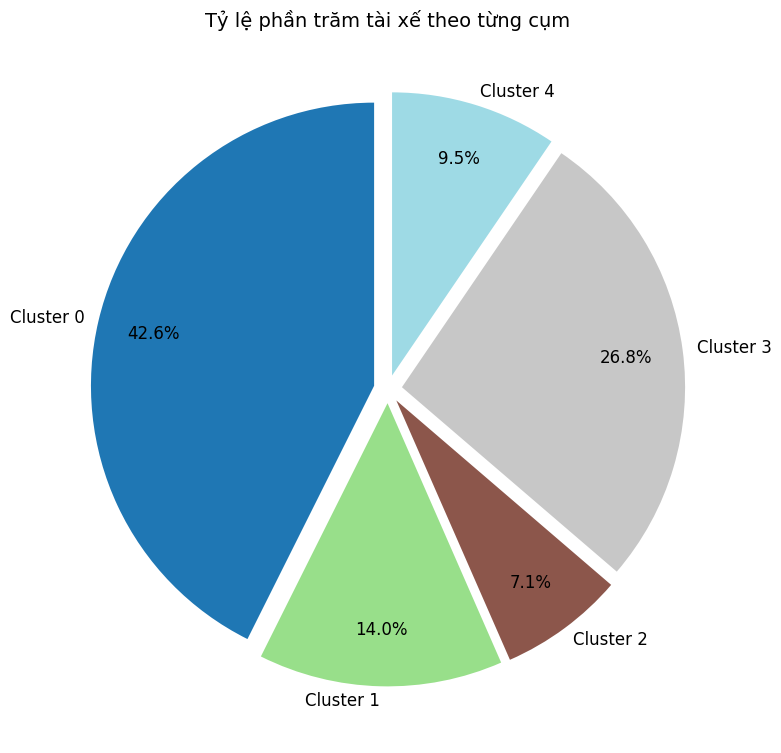

In [11]:
# ================================
# 1. Tính % phân bố cụm
# ================================
cluster_counts = person_cluster_df['cluster'].value_counts(normalize=True).sort_index() * 100

# ================================
# 2. Vẽ Pie Chart tối ưu
# ================================
fig, ax = plt.subplots(figsize=(8, 8))

# Tự sinh màu theo số cụm bằng colormap
colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_counts)))

# Tự tạo explode nhẹ cho từng cụm
explode = [0.05] * len(cluster_counts)

ax.pie(
    cluster_counts.values,
    labels=[f"Cluster {i}" for i in cluster_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    pctdistance=0.8,         # Giữ khoảng cách % rõ hơn
    labeldistance=1.05,      # Giữ khoảng cách nhãn đẹp hơn
    textprops={'fontsize': 12}
)

ax.set_title("Tỷ lệ phần trăm tài xế theo từng cụm", fontsize=14)
plt.tight_layout()
plt.show()


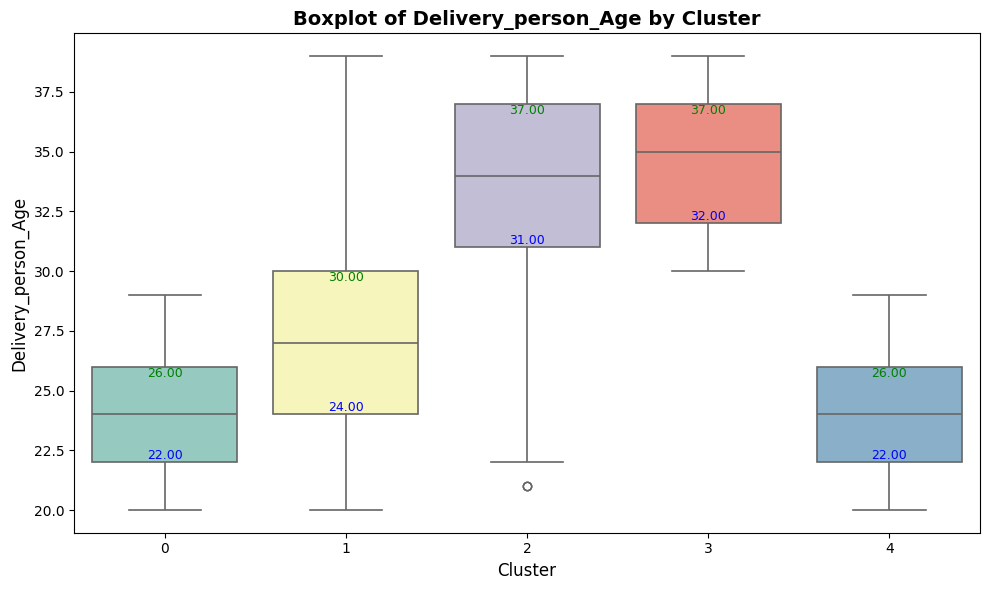

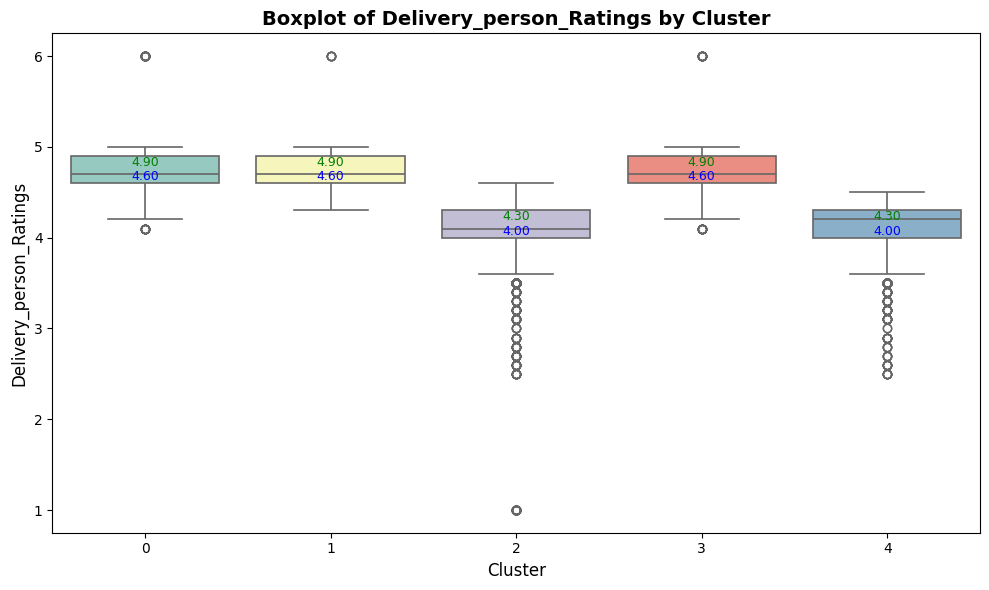

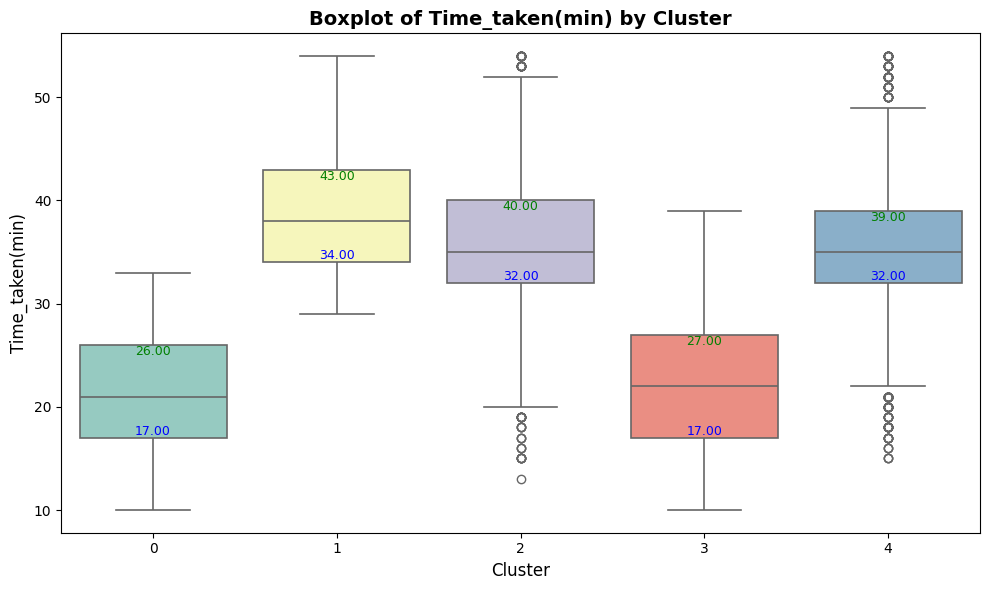

In [ ]:
# ================================
# Vẽ boxplot cho từng feature theo cụm
# ================================

features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Time_taken(min)']

for feature in features:
    plt.figure(figsize=(10, 6))

    # Boxplot theo cluster
    ax = sns.boxplot(
        data=person_cluster_df, 
        x='cluster', 
        y=feature, 
        palette='Set3',        # Màu đẹp hơn pastel
        linewidth=1.2
    )

    # Tiêu đề & nhãn
    plt.title(f'Boxplot of {feature} by Cluster', fontsize=14, weight='bold')
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(feature, fontsize=12)

    # Tự động duyệt qua các cluster theo thứ tự
    clusters = sorted(person_cluster_df['cluster'].unique())

    for i, cluster in enumerate(clusters):
        stats = person_cluster_df[person_cluster_df['cluster'] == cluster][feature].describe()
        q1 = stats['25%']
        q3 = stats['75%']

        # Q1
        ax.text(
            i, q1, f"{q1:.2f}", 
            ha="center", va="bottom",
            fontsize=9, color='blue'
        )

        # Q3
        ax.text(
            i, q3, f"{q3:.2f}", 
            ha="center", va="top",
            fontsize=9, color='green'
        )

    plt.tight_layout()
    plt.show()


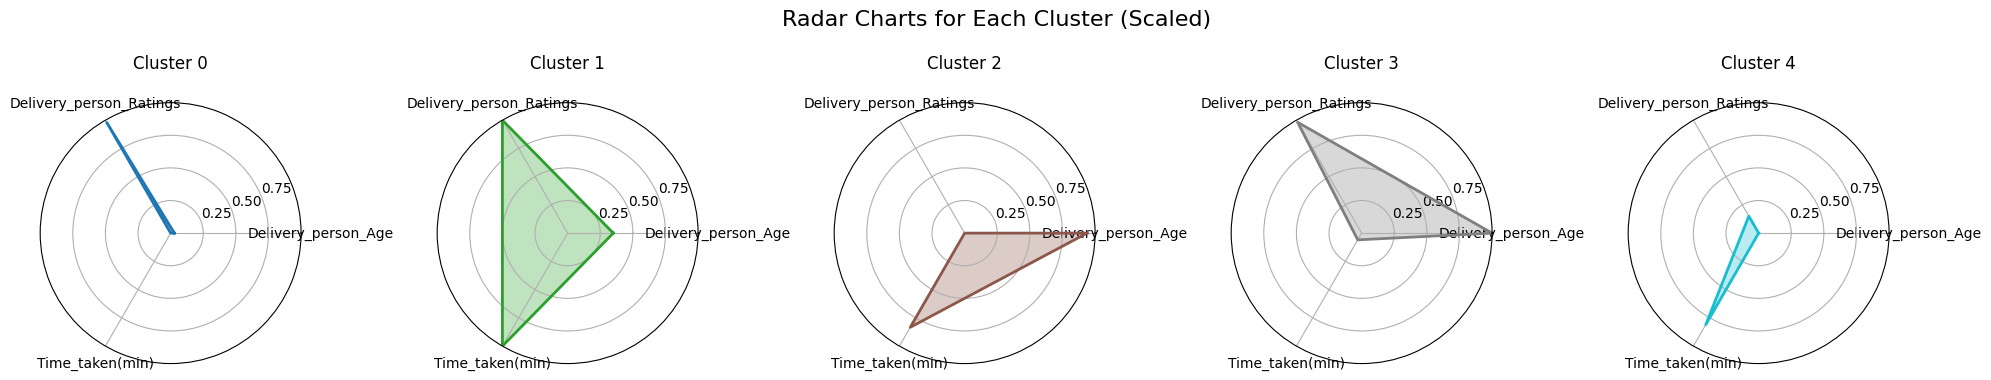

In [ ]:
# ================================
# 1. Tính trung bình theo từng cụm
# ================================
cluster_means = person_cluster_df.groupby("cluster")[selected_features].mean()

# ================================
# 2. Chuẩn bị thông tin radar chart
# ================================
categories = selected_features
N = len(categories)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]   # khép vòng tròn

# ================================
# 3. Normalize dữ liệu (0–1)
# ================================
scaler = MinMaxScaler()
cluster_means_scaled = scaler.fit_transform(cluster_means)

# ================================
# 4. Vẽ radar chart cho từng cụm
# ================================
fig, axs = plt.subplots(
    1, k,
    subplot_kw=dict(polar=True),
    figsize=(4 * k, 4)
)

# Nếu chỉ có 1 cluster, chuyển axs về dạng list
if k == 1:
    axs = [axs]

# Tự sinh màu đẹp bằng colormap
colors = plt.cm.tab10(np.linspace(0, 1, k))

for i in range(k):
    ax = axs[i]

    values = cluster_means_scaled[i].tolist()
    values += values[:1]  # khép vòng tròn

    # Vẽ line + fill
    ax.plot(angles, values, color=colors[i], linewidth=2)
    ax.fill(angles, values, color=colors[i], alpha=0.3)

    # Tiêu đề
    ax.set_title(f"Cluster {i}", size=12, y=1.1)

    # Nhãn trục
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    ax.set_yticks([0.25, 0.5, 0.75])
    ax.set_yticklabels(['0.25', '0.50', '0.75'])
    ax.set_ylim(0, 1)

plt.suptitle("Radar Charts for Each Cluster (Scaled)", fontsize=16)
plt.tight_layout()
plt.show()
